In [31]:
#Módulos

from scipy import optimize
from scipy.integrate import odeint
from IPython.display import display, Math, Markdown
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import locale
import datetime

locale.setlocale(locale.LC_TIME, 'es_ES')

'es_ES'

In [32]:
# Modelo SIR

def SIRderiv(params, t, N, beta, gamma):
    S, I, R = params
    dS = -beta*I*S/N
    dI = beta*I*S/N - gamma*I
    dR = gamma*I
    return dS, dI, dR

In [33]:
# Parseo y procesamiento de datos reales

rawData = pd.read_csv("casos_chile.csv")
procData = rawData[["Casos Nuevos"]]
procData.rename(columns={"Casos Nuevos":"Casos diarios"}, inplace=True)

newRecoveredPerDay = []
lastDayRecovered = 0
for currentDayRecovered in rawData["Recuperados"]:
    newRecoveredPerDay.append(currentDayRecovered - lastDayRecovered)
    if not np.isnan(currentDayRecovered):
        lastDayRecovered = currentDayRecovered
procData["Recuperados diarios"] = newRecoveredPerDay
        
newDeceasedPerDay = []
lastDayDeceased = 0
for currentDayDeceased in rawData["Fallecidos"]:
    newDeceasedPerDay.append(currentDayDeceased - lastDayDeceased)
    if not np.isnan(currentDayDeceased):
        lastDayDeceased = currentDayDeceased
procData["Fallecidos diarios"] = newDeceasedPerDay

/opt/apps/easybuild/software/Anaconda3/2019.03/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/apps/easybuild/software/Anaconda3/2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/apps/easybuild/software/Anaconda3/2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [34]:
#procData = procData.iloc[13:]

In [35]:
# Adelantar datos de infectados
daysMoved = 0

if daysMoved > 0:
    initialInfected = 0
    for iii in procData["Casos diarios"].tolist()[0:daysMoved-1]:
        initialInfected += iii
    correctedInfectedPerDay = [initialInfected]
    for iii in procData["Casos diarios"].tolist()[daysMoved:]:
        correctedInfectedPerDay.append(iii)
    newColumn = pd.DataFrame({'Casos corregidos':correctedInfectedPerDay})
    procData = pd.concat([procData,newColumn], axis=1)
    infectedDataToUse = "Casos corregidos"
else:
    initialInfected = 2
    infectedDataToUse = "Casos diarios"

# Procesar datos para modelo SIR
totalInfectedPerDay = []
totalRemovedPerDay = []
#Condiciones iniciales
currentInfected = 0
currentRemoved = 0
for index, row in procData.iterrows():
    newInfected, newRecovered, newDeceased = row[infectedDataToUse], row["Recuperados diarios"], row["Fallecidos diarios"]
    #if not np.isnan(newInfected):
    currentInfected += newInfected
    if not np.isnan(newRecovered):
        currentInfected -= newRecovered
        currentRemoved += newRecovered
    if not np.isnan(newDeceased):
        currentInfected -= newDeceased
        currentRemoved += newDeceased
    totalInfectedPerDay.append(currentInfected)
    totalRemovedPerDay.append(currentRemoved)

SIRExperimentalData = pd.DataFrame()
SIRExperimentalData["Infectados"] = totalInfectedPerDay
SIRExperimentalData["Removidos"] = totalRemovedPerDay
SIRExperimentalData.index.names = ["Día"]
SIRExperimentalData.reset_index(inplace=True)

 gamma: 0.0666(0.0) 	 beta: 0.19876905512877474(4.19989043543012e-12))5027889309237522)
Periodo infeccioso: 15.015015015015013
Ritmo reproductivo: 2.9845203472788997


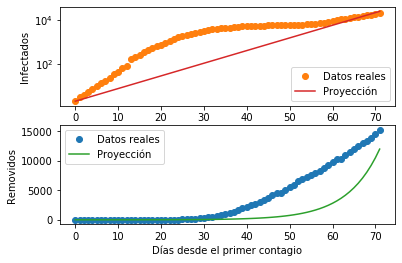

In [36]:
#Optimizar parámetro de contagio

def calculate_standard_error(observedResults, predictedResults):
    if (len(observedResults) != len(predictedResults)):
        print("ERROR: Los resultados observados y predichos no poseen el mismo número de datos")
        return 0
    squaredDeviations = []
    for obsY, predY in zip(observedResults, predictedResults):
        squaredDeviations.append(np.power(obsY-predY, 2))
    return np.sqrt( np.sum(squaredDeviations)/len(observedResults) )

def calculate_correlation_coefficient(observedResults, predictedResults):
    if (len(observedResults) != len(predictedResults)):
        print("ERROR: Los resultados observados y predichos no poseen el mismo número de datos")
        return 0
    correlation_matrix = np.corrcoef(observedResults, predictedResults)
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2
    return r_squared

def chi_squared(observedResults, predictedResults):
    if (len(observedResults) != len(predictedResults)):
        print("ERROR: Los resultados observados y predichos no poseen el mismo número de datos")
        return 0
    squaredDeviations = []
    for obsY, predY in zip(observedResults, predictedResults):
        squaredDeviations.append(np.power(obsY-predY, 2))
    return np.sum(squaredDeviations)
        
def integrate_SIR_model(initialConditions, days, population, beta, gamma):
    ret = odeint(SIRderiv, initialConditions, days, args=(population, beta, gamma))
    suceptible, infected, removed = ret.T
    resultDataFrame = pd.DataFrame()
    resultDataFrame["Día"] = days
    resultDataFrame["Suceptibles"] = suceptible
    resultDataFrame["Infectados"] = infected
    resultDataFrame["Removidos"] = removed
    return resultDataFrame

def clean_data(dataFrame, columnOfInterest):
    dirtyColumn = dataFrame[[columnOfInterest]]
    cleanColumn = dirtyColumn.dropna()
    return cleanColumn

def error_from_gamma(gamma, beta, initialConditions, population, experimentalData):
    cleanData = clean_data(experimentalData, "Removidos")
    resultingSIR = integrate_SIR_model(initialConditions, np.arange(len(cleanData)), population, beta, gamma)
    experimentalInfected = experimentalData["Removidos"].to_numpy()
    predictedInfected = resultingSIR["Removidos"].to_numpy()
    return calculate_standard_error(experimentalInfected, predictedInfected)

def error_from_beta(beta, gamma, initialConditions, population, experimentalData):
    resultingSIR = integrate_SIR_model(initialConditions, np.arange(len(experimentalData)), population, beta, gamma)
    experimentalInfected = experimentalData["Infectados"].to_numpy()
    predictedInfected = resultingSIR["Infectados"].to_numpy()
    return calculate_standard_error(experimentalInfected, predictedInfected)

# Total de habitantes
N = 19107216 #Fuente: INE

# Condiciones iniciales
I0 = 2*1 #Infectados
R0 = 0 #Removidos
S0 = N - I0 - R0

initConditions = (S0, I0, R0)

# Parámetros
Rn0 = 2.5 #Ritmo reproductivo, n° de contagios por infectado por día
TR = 14  #Periodo infeccioso en días

gamma = 1/TR
beta = gamma*Rn0

optimizedBeta = gamma*Rn0
iter = 0
iterMax = 50
threshold = 10e-10
while iter < iterMax:
    betaOptimizationResult = optimize.minimize(error_from_beta,
                                           x0=beta,
                                           args=(gamma, initConditions, N, SIRExperimentalData),
                                           bounds=[(0.1, 10)])
    optimizedBeta = float(betaOptimizationResult.x)
    gammaOptimizationResult = optimize.minimize(error_from_gamma,
                                            x0=gamma,
                                            args=(optimizedBeta, initConditions, N, SIRExperimentalData),
                                            bounds=[(0.0666, 0.0769)])
    optimizedGamma = float(gammaOptimizationResult.x)
    
    gammaDelta, betaDelta = optimizedGamma-gamma, optimizedBeta-beta
    gamma, beta = optimizedGamma, optimizedBeta
    iter += 1
    print("\r gamma: {}({}) \t beta: {}({})".format(gamma,gammaDelta, beta,betaDelta), end='')
    if (abs(gammaDelta) <= threshold) and (abs(betaDelta) <= threshold):
        print("")
        break
else:
    print("Warning: Reached {0} iterations".format(iterMax))
optimizedTR = 1/optimizedGamma
optimizedRn0 = optimizedBeta/optimizedGamma
print("Periodo infeccioso: {0}\nRitmo reproductivo: {1}".format(optimizedTR, optimizedRn0))

optimizedSIR = integrate_SIR_model(initConditions, np.arange(len(SIRExperimentalData)), N, optimizedBeta, optimizedGamma)

figure = plt.figure()
SIRInfectedPlot = figure.add_subplot(211)
SIRInfectedPlot.plot(SIRExperimentalData["Día"], SIRExperimentalData["Infectados"], 'o', color="C1", label="Datos reales")
SIRInfectedPlot.plot(SIRExperimentalData["Día"], optimizedSIR["Infectados"], color="C3", label="Proyección")
plt.legend()
plt.yscale("log")
plt.ylabel("Infectados")


SIRRemovedPlot = figure.add_subplot(212)
SIRRemovedPlot.plot(SIRExperimentalData["Día"], SIRExperimentalData["Removidos"], 'o', color="C0", label="Datos reales")
SIRRemovedPlot.plot(SIRExperimentalData["Día"], optimizedSIR["Removidos"], color="C2", label="Proyección")
plt.legend()
plt.ylabel("Removidos")
plt.xlabel("Días desde el primer contagio")

plt.show()

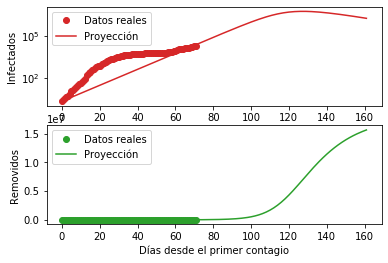

In [37]:
optimizedSIR = integrate_SIR_model(initConditions, np.arange(len(SIRExperimentalData)+90), N, optimizedBeta, optimizedGamma)

figure = plt.figure()
SIRInfectedPlot = figure.add_subplot(211)
SIRInfectedPlot.plot(SIRExperimentalData["Día"], SIRExperimentalData["Infectados"], 'o', color="C3", label="Datos reales")
SIRInfectedPlot.plot(optimizedSIR["Día"], optimizedSIR["Infectados"], color="C3", label="Proyección")
plt.legend()
plt.yscale("log")
plt.ylabel("Infectados")


SIRRemovedPlot = figure.add_subplot(212)
SIRRemovedPlot.plot(SIRExperimentalData["Día"], SIRExperimentalData["Removidos"], 'o', color="C2", label="Datos reales")
SIRRemovedPlot.plot(optimizedSIR["Día"], optimizedSIR["Removidos"], color="C2", label="Proyección")
plt.legend()
plt.ylabel("Removidos")
plt.xlabel("Días desde el primer contagio")
plt.show()

In [38]:
lastDay = len(SIRExperimentalData)
nextDayNewInfected = optimizedSIR.loc[lastDay+1, "Infectados"] - optimizedSIR.loc[lastDay, "Infectados"]
nextDayNewRecovered = optimizedSIR.loc[lastDay+1, "Removidos"] - optimizedSIR.loc[lastDay, "Removidos"]

newConfirmed = nextDayNewInfected + nextDayNewRecovered

print("Delta de infectados: {0}".format(int(nextDayNewInfected)))

print("{0} nuevos casos proyectados.".format(int(newConfirmed)))

Delta de infectados: 3810
5737 nuevos casos proyectados.
